In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

from sklearn.datasets import make_classification, make_blobs, make_spd_matrix
from scipy.spatial.distance import pdist, squareform

import sys
sys.path.append('C:\\Users\\Shagesh\\Documents\\Python Scripts\\python_work\\mantis-master')
from mantis import sdp_km_burer_monteiro
from numpy.linalg import eigh

from drawnow import drawnow, figure
from pylab import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - Transformed Shape:', train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

C:\Users\Shagesh\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [3]:
#[X, Y] = make_blobs(1000, 10, 3, shuffle = True)

In [4]:
data = torch.from_numpy(X)

categories = torch.from_numpy(Y)

# Create DataLoader
#dataloader_args = dict(shuffle=True, batch_size=1,num_workers=1, pin_memory=True)
#train_loader = dataloader.DataLoader(train, **dataloader_args)
#test_loader = dataloader.DataLoader(test, **dataloader_args)

In [10]:
Y = sdp_km_burer_monteiro(X, 20, rank=len(X),
                                  tol=1e-6, maxiter=5000, verbose=True)

   0 | Y bounds 0.00000 0.00393 | constraints -16.8442150203 0.0527294758 | E 1.8284784615
   1 | Y bounds 0.00000 0.00392 | constraints -16.8483612611 0.0506906411 | E 0.0006925559
   2 | Y bounds 0.00000 0.00392 | constraints -16.8483932093 0.0505946532 | E 0.0000243771
   3 | Y bounds 0.00000 0.00392 | constraints -16.8483393857 0.0506109173 | E 0.0000100497
   4 | Y bounds 0.00000 0.00392 | constraints -16.8483652612 0.0506016480 | E 0.0000048113
   5 | Y bounds 0.00000 0.00392 | constraints -16.8483652612 0.0506016480 | E 0.0000000000


## Model

In [4]:
class Model(nn.Module):
    def __init__(self, n_inputs, n_neurons, Wx_in, Wy_in, Y_hat_in, u_plus_in, u_minus_in, Wx_learning_rate, Wy_learning_rate, u_plus_lr, u_minus_lr ):
        super(Model, self).__init__()
        
        self.Wx = Wx_in.float() # n_neurons x n_input
        self.Wy = Wy_in.float() # n_neurons X n_neurons
        self.Y_hat = Y_hat_in.float() # n_neurons x 1
        self.u_plus = u_plus_in.float() # n_neurons x 1
        self.u_minus = u_minus_in.float() # n_neurons x 1
        
        self.Y0 = 10**-2*torch.randn(n_neurons, 1).float() # n_neurons x 1
        self.alpha = 10**-2*torch.randn(1)
        self.lambdaM = 10**-2*torch.randn(1)
        self.beta = 2
        
        self.eta = 10**-3 # learning rate
        self.eta_alpha = 1 # learning rate        
        self.eta_Wx = Wx_learning_rate
        self.eta_lambdaM = Wy_learning_rate
        self.eta_u_plus = u_plus_lr
        self.eta_u_minus = u_minus_lr
        self.ceiling = 100 # maximum activity
        self.input_size = n_inputs
        self.neuron_size = n_neurons
        self.error_Wx = 10**5
        self.error_Wy = 10**5
        self.limit = 10**5
    
    def forward(self, X1):
        X1 = X1.float()
        Y_derivative = torch.mm(self.Wx, X1) - 0.5 * (10**0* self.alpha) * (self.u_plus - self.u_minus) - 10**0 * self.lambdaM * self.Y0 - 10**0 * 0.5 * (self.u_plus + self.u_minus) # batch_size X n_neurons, highest activity 100
#        if torch.mm(Y_derivative.T, Y_derivative).item()/torch.mm(self.Y0.T, self.Y0) > 10:
#            self.eta *= 0.1
#        else:
#            self.eta *= 2
        alpha_derivative = (torch.mm(0.5 * (self.u_plus - self.u_minus).T, torch.mm(self.Wx, X1)) - self.lambdaM - 0.25 * torch.mm((self.u_plus + self.u_minus).T, (self.u_plus - self.u_minus)))/(0.25 * torch.mm((self.u_plus - self.u_minus).T, (self.u_plus - self.u_minus)))
        return Y_derivative, alpha_derivative
    
    def updateYandalpha(self, Y_in, alpha_in):
        Y_in = Y_in.float()
        self.Y0 = self.Y0 + self.eta*(Y_in)
        self.Y0[self.Y0 < 0] = 0
        self.alpha = self.eta_alpha*(alpha_in)
        if torch.isnan(self.alpha):
            self.alpha = torch.randn(1)
        self.Y0[torch.isnan(self.Y0)] = torch.ones(self.neuron_size, 1).float()[torch.isnan(self.Y0)]
        self.Y0[self.Y0 > self.limit] = torch.ones(self.neuron_size, 1).float()[self.Y0 > self.limit]
        return self.Y0, self.alpha

    def updatelambdaM(self, outputs):
        outputs = outputs.float()
        change_lambdaM = torch.mm(outputs.T, outputs) - self.beta
#        if torch.abs(change_lambdaM).item()/torch.abs(self.lambdaM) > 10:
#            self.eta_lambdaM *= 0.1
#        else:
#            self.eta_lambdaM *= 2
        self.lambdaM += self.input_size*self.eta_lambdaM*change_lambdaM[0]
        self.lambdaM[torch.isnan(self.lambdaM)] = torch.randn(1)

    def updateWx(self, outputs, inputs):
        inputs = inputs.float()
        outputs = outputs.float()
        change_Wx = torch.mm(outputs, inputs.T) - self.Wx
#        if torch.mm(change_Wx.view(1, -1), change_Wx.view(1, -1).T)/torch.mm(self.Wx.view(1, -1), self.Wx.view(1, -1).T) > 10:
#            self.eta_Wx *= 0.1
#        else:
#            self.eta_Wx *= 2
        self.Wx += self.eta_Wx*change_Wx
        self.Wx[torch.isnan(self.Wx)] = torch.randn(self.neuron_size, self.input_size).float()[torch.isnan(self.Wx)]
        self.Wx[self.Wx > self.limit] = torch.ones(self.neuron_size, self.input_size).float()[self.Wx > self.limit]
        
    def updateuplus(self, outputs):
        outputs = outputs.float()
        change_uplus = (self.alpha + 1)*outputs - self.u_plus
#        if torch.mm(change_uplus.T, change_uplus).item()/torch.mm(self.u_plus.T, self.u_plus) > 10:
#            self.eta_u_plus *= 0.1
#        else:
#            self.eta_u_plus *= 2
        self.u_plus = self.u_plus + self.eta_u_plus*change_uplus
        self.u_plus[torch.isnan(self.u_plus)] = torch.randn(self.neuron_size, 1).float()[torch.isnan(self.u_plus)]
        self.u_plus[self.u_plus > self.limit] = torch.ones(self.neuron_size, 1).float()[self.u_plus > self.limit]

    def updateuminus(self, outputs):
        outputs = outputs.float()
        change_uminus = (self.alpha - 1)*outputs - self.u_minus
#        if torch.mm(change_uminus.T, change_uminus).item()/torch.mm(self.u_minus.T, self.u_minus) > 10:
#            self.eta_u_minus *= 0.1
#        else:
#            self.eta_u_minus *= 2
        self.u_minus = self.u_minus + self.eta_u_minus*change_uminus
        self.u_minus[torch.isnan(self.u_minus)] = torch.randn(self.neuron_size, 1).float()[torch.isnan(self.u_minus)]
        self.u_minus[self.u_minus > self.limit] = torch.ones(self.neuron_size, 1).float()[self.u_minus > self.limit]


N_INPUT = 1*28*28 # number of features in input
N_NEURONS = 100 # number of units in layer
Wx_learning_rate_1 = 10**-5
Wy_learning_rate_1 = 10**-5
uplus_learning_rate_1 = 10**-3
uminus_learning_rate_1 = 10**-3

N_INPUT_2 = 20 # number of features in input
N_NEURONS_2 = 3 # number of units in layer
Wx_learning_rate_2 = 10**-5
Wy_learning_rate_2 = 10**-5
uplus_learning_rate_2 = 10**-3
uminus_learning_rate_2 = 10**-3

model = Model(N_INPUT, N_NEURONS, 10**0*torch.randn(N_NEURONS, N_INPUT), 1*torch.ones(N_NEURONS, N_NEURONS) - 1*torch.diag(torch.ones(N_NEURONS)), 10**0*torch.randn(N_NEURONS, 1), 10**0*torch.randn(N_NEURONS, 1), 10**0*torch.randn(N_NEURONS, 1), Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
model_2 = Model(N_INPUT_2, N_NEURONS_2, 10**0*torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), 10**0*torch.randn(N_NEURONS_2, 1), 10**0*torch.randn(N_NEURONS_2, 1), 10**0*torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)
criterion = torch.nn.MSELoss()
criterion_check = torch.nn.MSELoss()
model.cuda() # CUDA!
model_2.cuda() # CUDA!

Model()

In [ ]:
i = 0

In [ ]:
for k in range(10000):
    inputs = data[i]
    labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)

    # forward + backward + optimize
    old_output = model.Y0
    old_alpha = model.alpha
    derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
    outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
    loss = criterion(outputs, old_output)
    loss_alpha = criterion(alpha, old_alpha)
        
    j = 0
    while(loss + loss_alpha > 10**-5 and j < 10**5):
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, model.Y0)
        loss_alpha = criterion(alpha, old_alpha)
        j += 1
#        print(i, "loss:", loss)
        
    model.updateY_hat(outputs)
    model.updateWx(outputs, inputs.view(-1, 10).T)
    model.updateWy(outputs)        
    model.updateuplus(outputs)        
    model.updateuminus(outputs)        
    if k % 1000 == 999:
        print(criterion(outputs, model.Y0))
        f, axarr = plt.subplots(2,4)
        axarr[0, 0].imshow(model.Wx)
        axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(10, 1).T))
        axarr[0, 2].imshow(model.Wy)
        axarr[0, 3].imshow(torch.mm(outputs, outputs.T))
        axarr[1, 0].imshow(model.u_plus)
        axarr[1, 1].imshow((1 + model.alpha)*outputs)
        axarr[1, 2].imshow(model.u_minus)
        axarr[1, 3].imshow((1 - model.alpha)*outputs)
        plt.show()

In [ ]:
torch.mm(outputs.T, outputs)

In [ ]:
model.alpha

In [ ]:
derivativealpha

In [ ]:
for k in range(1):
    inputs = data[i]
    labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)

    # forward + backward + optimize
    old_output = model.Y0
    old_alpha = model.alpha
    derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
    outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
    loss = criterion(outputs, old_output)
    loss_alpha = criterion(alpha, old_alpha)
        
    j = 0
    while(loss + loss_alpha > 10**-5 and j < 10**3):
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, model.Y0)
        loss_alpha = criterion(alpha, old_alpha)
        model.updateuplus(outputs)        
        model.updateuminus(outputs)        
        j += 1
        print(j, "yt_y:", torch.mm(outputs.T, outputs), "   alpha:", alpha, "   loss:", loss + loss_alpha)
        
    model.updateY_hat(outputs)
    model.updateWx(outputs, inputs.view(-1, 10).T)
    model.updateWy(outputs)        
    if k % 1000 == 999:
        print(criterion(outputs, model.Y0))
        f, axarr = plt.subplots(2,4)
        axarr[0, 0].imshow(model.Wx)
        axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(10, 1).T))
        axarr[0, 2].imshow(model.Wy)
        axarr[0, 3].imshow(torch.mm(outputs, outputs.T))
        axarr[1, 0].imshow(model.u_plus)
        axarr[1, 1].imshow((1 + model.alpha)*outputs)
        axarr[1, 2].imshow(model.u_minus)
        axarr[1, 3].imshow((1 - model.alpha)*outputs)
        plt.show()

In [ ]:
torch.mm(outputs.T, outputs)

In [ ]:
0.5*torch.mm((model.u_plus - model.u_minus).T, outputs) - 1

In [ ]:
alpha

In [ ]:
derivativealpha

In [ ]:
model.eta_alpha

In [ ]:
print(criterion(outputs, model.Y0))
f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(model.Wx)
axarr[0, 1].imshow(torch.mm(outputs, inputs.float().view(2, 1).T))
axarr[1, 0].imshow(model.Wy)
axarr[1, 1].imshow(torch.mm(outputs, outputs.T))

In [ ]:
Y_arranged = Y[np.argsort(categories)]

In [ ]:
Q = np.dot(Y_arranged, Y_arranged.T)

In [ ]:
imshow(Q)
colorbar()

In [85]:
Wx_learning_rate_1 = 10**-3
Wy_learning_rate_1 = 10**-3
uplus_learning_rate_1 = 10**-3
uminus_learning_rate_1 = 10**-3

Wx_learning_rate_2 = 10**-7
Wy_learning_rate_2 = 10**-7
uplus_learning_rate_2 = 10**-7
uminus_learning_rate_2 = 10**-7
model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)
#model_2 = Model(N_INPUT_2, N_NEURONS_2, torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), torch.randn(N_NEURONS_2, 1), torch.randn(N_NEURONS_2, 1), torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)

In [22]:
%matplotlib qt
model.train()
output_compare = torch.ones(10, N_NEURONS)
#output_compare_2 = torch.ones(10, 10)
#distance = torch.zeros((600, N_NEURONS))
#distance_2 = torch.zeros((60000, 3))

#x = torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T)
#x_hat = torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T)

for epoch in range(1):
    loss_check = 0
    check_alpha = 0
    for i, (inputs, labels) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)

        # forward + backward + optimize
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, N_INPUT).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, old_output)
        loss_alpha = criterion(alpha, old_alpha)
        
        j = 0
        while(loss + loss_alpha > 10**-5 and j < 10**3):
            old_output = model.Y0
            old_alpha = model.alpha
            derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, N_INPUT).T)
            outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
            loss = criterion(outputs, model.Y0)
            loss_alpha = criterion(alpha, old_alpha)
            j += 1
#            if j % 100 == 99:
#                print(j, "loss:", loss_alpha)
        
        model.updateWx(outputs, inputs.view(-1, N_INPUT).T)
        model.updatelambdaM(outputs)        
        model.updateuplus(outputs)        
        model.updateuminus(outputs)        

        # forward + backward + optimize
#        old_output_2 = model_2.Y0
#        old_alpha_2 = model_2.alpha
#        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
#        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
#        loss_2 = criterion(outputs_2, old_output_2)
#        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
#        j = 0
#        while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**2):
#            old_output_2 = model_2.Y0
#            old_alpha_2 = model_2.alpha
#            derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
#            outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
#            loss_2 = criterion(outputs_2, old_output_2)
#            loss_alpha_2 = criterion(alpha_2, old_alpha_2)
#            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
#        model_2.updateWx(outputs_2, outputs)
#        model_2.updatelambdaM(outputs_2)        
#        model_2.updateuplus(outputs_2)        
#        model_2.updateuminus(outputs_2)        
        
        loss_check += criterion_check(outputs.view(-1, N_NEURONS), output_compare[labels].view(-1, N_NEURONS))
        output_compare[labels] = outputs.T
#        distance[i%600] = outputs.T
                
#        loss_check_2 = criterion_check(outputs_2.T[0], output_compare_2[labels])
#        output_compare_2[labels] = outputs_2.T
#        distance_2[i] = outputs_2.T

        check_alpha += torch.abs(model.alpha).item()

#        w, v = eigh(torch.mm(distance, distance.T))
#        x = w[580:]
#        x = squareform(pdist(distance_2[np.argsort(categories)]))
#        x_hat = model.Wx
        
#        constraint_check = torch.sum(torch.sum(torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T), axis = 0))/1000
        
        # Display
        if i % 600 == 599:
#            drawnow(draw_fig_1)
#            drawnow(draw_fig_2)
#            plt.pause(0.000000001)
            print('\r Epoch: {} [{}/{} ({:.0f}%)]\ty_v: {:2f}\talpha: {:2f}\tSum: {:1f}'.format(
                epoch, 
                i , 
                60000,
                100. * (i+1) / 60000, 
                0.5*torch.mm(model.Y0.T, model.u_plus - model.u_minus).item(),
                check_alpha/(i+1),
                loss_check/(i+1)), 
                end='')
            
    print()
#    if constraint_check > 5*10**3:
#        change_in_rate_W = 0.1
#    else:
#        change_in_rate_W = 1.1
#    if torch.sum(torch.mul(model.u_plus - model.u_minus, model.u_plus - model.u_minus)) > 5*10**3:
#        change_in_rate_alpha = 0.1
#    else:
#        change_in_rate_alpha = 1.1
#    Wx_learning_rate_1 *= change_in_rate_W
#    Wy_learning_rate_1 *= change_in_rate_W
#    uplus_learning_rate_1 *= change_in_rate_alpha
#    uminus_learning_rate_1 *= change_in_rate_alpha
#    model.eta *= change_in_rate_W

#    Wx_learning_rate_2 *= change_in_rate_W
#    Wy_learning_rate_2 *= change_in_rate_W
#    uplus_learning_rate_2 *= change_in_rate_W
#    uminus_learning_rate_2 *= change_in_rate_W
#    model_2.eta *= change_in_rate_W
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)

 Epoch: 0 [59999/60000 (100%)]	y_v: 0.002382	alpha: 81.531634	Sum: 0.000234


In [23]:
%matplotlib qt
model.train()
output_compare = torch.ones(10, N_NEURONS)
#output_compare_2 = torch.ones(10, 10)
distance = torch.zeros((10000, N_NEURONS))
output_labels = torch.zeros(10000)
#distance_2 = torch.zeros((60000, 3))

#x = torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T)
#x_hat = torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T)

for epoch in range(1):
    loss_check = 0
    check_alpha = 0
    for i, (inputs, labels) in enumerate(test_loader):
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)

        # forward + backward + optimize
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, N_INPUT).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, old_output)
        loss_alpha = criterion(alpha, old_alpha)
        
        j = 0
        while(loss + loss_alpha > 10**-5 and j < 10**3):
            old_output = model.Y0
            old_alpha = model.alpha
            derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, N_INPUT).T)
            outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
            loss = criterion(outputs, model.Y0)
            loss_alpha = criterion(alpha, old_alpha)
            j += 1
#            if j % 100 == 99:
#                print(j, "loss:", loss_alpha)
        
#        model.updateWx(outputs, inputs.view(-1, N_INPUT).T)
#        model.updatelambdaM(outputs)        
#        model.updateuplus(outputs)        
#        model.updateuminus(outputs)        

        # forward + backward + optimize
#        old_output_2 = model_2.Y0
#        old_alpha_2 = model_2.alpha
#        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
#        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
#        loss_2 = criterion(outputs_2, old_output_2)
#        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
#        j = 0
#        while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**2):
#            old_output_2 = model_2.Y0
#            old_alpha_2 = model_2.alpha
#            derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
#            outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
#            loss_2 = criterion(outputs_2, old_output_2)
#            loss_alpha_2 = criterion(alpha_2, old_alpha_2)
#            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
#        model_2.updateWx(outputs_2, outputs)
#        model_2.updatelambdaM(outputs_2)        
#        model_2.updateuplus(outputs_2)        
#        model_2.updateuminus(outputs_2)        
        
        loss_check += criterion_check(outputs.view(-1, N_NEURONS), output_compare[labels].view(-1, N_NEURONS))
        output_compare[labels] = outputs.T
        distance[i] = outputs.T
        output_labels[i] = labels
                
#        loss_check_2 = criterion_check(outputs_2.T[0], output_compare_2[labels])
#        output_compare_2[labels] = outputs_2.T
#        distance_2[i] = outputs_2.T

        check_alpha += torch.abs(model.alpha).item()

#        w, v = eigh(torch.mm(distance, distance.T))
#        x = w[580:]
#        x = squareform(pdist(distance_2[np.argsort(categories)]))
#        x_hat = model.Wx
        
#        constraint_check = torch.sum(torch.sum(torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T), axis = 0))/1000
        
        # Display
        if i % 500 == 499:
#            drawnow(draw_fig_1)
#            drawnow(draw_fig_2)
#            plt.pause(0.000000001)
            print('\r Epoch: {} [{}/{} ({:.0f}%)]\ty_v: {:2f}\talpha: {:2f}\tSum: {:1f}'.format(
                epoch, 
                i , 
                10000,
                100. * (i+1) / 10000, 
                0.5*torch.mm(model.Y0.T, model.u_plus - model.u_minus).item(),
                check_alpha/(i+1),
                loss_check/(i+1)), 
                end='')
            
    print()
#    if constraint_check > 5*10**3:
#        change_in_rate_W = 0.1
#    else:
#        change_in_rate_W = 1.1
#    if torch.sum(torch.mul(model.u_plus - model.u_minus, model.u_plus - model.u_minus)) > 5*10**3:
#        change_in_rate_alpha = 0.1
#    else:
#        change_in_rate_alpha = 1.1
#    Wx_learning_rate_1 *= change_in_rate_W
#    Wy_learning_rate_1 *= change_in_rate_W
#    uplus_learning_rate_1 *= change_in_rate_alpha
#    uminus_learning_rate_1 *= change_in_rate_alpha
#    model.eta *= change_in_rate_W

#    Wx_learning_rate_2 *= change_in_rate_W
#    Wy_learning_rate_2 *= change_in_rate_W
#    uplus_learning_rate_2 *= change_in_rate_W
#    uminus_learning_rate_2 *= change_in_rate_W
#    model_2.eta *= change_in_rate_W
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)

 Epoch: 0 [9999/10000 (100%)]	y_v: 0.002173	alpha: 64.415819	Sum: 0.001058


Populating the interactive namespace from numpy and matplotlib


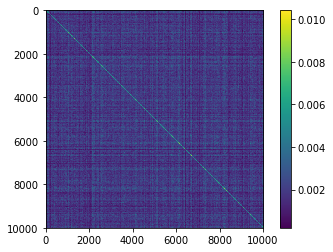

In [24]:
%pylab inline
imshow(torch.mm(distance[np.argsort(output_labels)], distance[np.argsort(output_labels)].T))
colorbar()

In [ ]:
Wx_learning_rate_1 = 10**-5
Wy_learning_rate_1 = 10**-5
uplus_learning_rate_1 = 10**-3
uminus_learning_rate_1 = 10**-3

Wx_learning_rate_2 = 10**-5
Wy_learning_rate_2 = 10**-5
uplus_learning_rate_2 = 10**-3
uminus_learning_rate_2 = 10**-3
model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
#model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)
model_2 = Model(N_INPUT_2, N_NEURONS_2, 10**0*torch.randn(N_NEURONS_2, N_INPUT_2), 1*torch.ones(N_NEURONS_2, N_NEURONS_2) - 1*torch.diag(torch.ones(N_NEURONS_2)), 10**0*torch.randn(N_NEURONS_2, 1), 10**0*torch.randn(N_NEURONS_2, 1), 10**0*torch.randn(N_NEURONS_2, 1), Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)

In [36]:
%matplotlib qt
#model.train()
#output_compare = torch.ones(3, 20)
#output_compare_2 = torch.ones(3, 3)
#distance = torch.zeros((1000, 20))
#distance_2 = torch.zeros((1000, 3))

x = torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T)
x_hat = torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T)

for epoch in range(100):
    loss_check = 0
    check_alpha = 0
    for i in range(1000):
        inputs = data[i]
        labels = categories[i]
        # get the inputs; data is a list of [inputs, labels]
        model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
        model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)

        # forward + backward + optimize
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, old_output)
        loss_alpha = criterion(alpha, old_alpha)
        
        j = 0
        while(loss + loss_alpha > 10**-5 and j < 10**3):
            old_output = model.Y0
            old_alpha = model.alpha
            derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
            outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
            loss = criterion(outputs, model.Y0)
            loss_alpha = criterion(alpha, old_alpha)
            j += 1
#            if j % 100 == 99:
#                print(j, "loss:", loss_alpha)
        
#        model.updateWx(outputs, inputs.view(-1, 10).T)
#        model.updatelambdaM(outputs)        
#        model.updateuplus(outputs)        
#        model.updateuminus(outputs)        

        # forward + backward + optimize
        old_output_2 = model_2.Y0
        old_alpha_2 = model_2.alpha
        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
        loss_2 = criterion(outputs_2, old_output_2)
        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
        model_2.eta = 10**-1
        j = 0
        while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**2):
            old_output_2 = model_2.Y0
            old_alpha_2 = model_2.alpha
            derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
            outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
            loss_2 = criterion(outputs_2, old_output_2)
            loss_alpha_2 = criterion(alpha_2, old_alpha_2)
            j += 1
#            if j % 1000 == 999:
#                print(j, "loss:", loss)
        
        model_2.updateWx(outputs_2, outputs)
        model_2.updatelambdaM(outputs_2)        
        model_2.updateuplus(outputs_2)        
        model_2.updateuminus(outputs_2)        
        
#        loss_check += criterion_check(outputs.T[0], output_compare[labels])
#        output_compare[labels] = outputs.T
#        distance[i] = outputs.T
                
        loss_check_2 = criterion_check(outputs_2.T[0], output_compare_2[labels])
        output_compare_2[labels] = outputs_2.T
        distance_2[i] = outputs_2.T

        check_alpha += torch.abs(model.alpha).item()

#        x = torch.mm(distance[np.argsort(categories)], distance[np.argsort(categories)].T)
        x = torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T)
        x_hat = model_2.Wx
        
        constraint_check = torch.sum(torch.sum(torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T), axis = 0))/1000
        
        # Display
        if i % 50 == 49:
#            drawnow(draw_fig_1)
            drawnow(draw_fig_2)
            plt.pause(0.000000001)
            print('\r Epoch: {} [{}/{} ({:.0f}%)]\ty_v: {:2f}\talpha: {:2f}\tW: {:2f}\tU: {:2f}\tSum: {:1f}'.format(
                epoch, 
                i , 
                1000,
                100. * (i+1) / 1000, 
                0.5*torch.mm(model_2.Y0.T, model_2.u_plus - model_2.u_minus).item(),
                check_alpha/(i+1),
                model_2.eta_Wx, 
                uplus_learning_rate_1,
                constraint_check), 
                end='')
            
    print()
    if constraint_check > 5*10**3:
        change_in_rate_W = 0.1
    else:
        change_in_rate_W = 1.1
    if torch.sum(torch.mul(model_2.u_plus - model_2.u_minus, model_2.u_plus - model_2.u_minus)) > 5*10**3:
        change_in_rate_alpha = 0.1
    else:
        change_in_rate_alpha = 1.1
#    Wx_learning_rate_1 *= change_in_rate_W
#    Wy_learning_rate_1 *= change_in_rate_W
#    uplus_learning_rate_1 *= change_in_rate_alpha
#    uminus_learning_rate_1 *= change_in_rate_alpha
#    model.eta *= change_in_rate_W

#    Wx_learning_rate_2 *= change_in_rate_W
#    Wy_learning_rate_2 *= change_in_rate_W
#    uplus_learning_rate_2 *= change_in_rate_W
#    uminus_learning_rate_2 *= change_in_rate_W
#    model_2.eta *= change_in_rate_W
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, Wx_learning_rate_1, Wy_learning_rate_1, uplus_learning_rate_1, uminus_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, Wx_learning_rate_2, Wy_learning_rate_2, uplus_learning_rate_2, uminus_learning_rate_2)

 Epoch: 0 [999/1000 (100%)]	y_v: 0.232543	alpha: 188.138732	W: 0.000010	U: 0.001000	Sum: 130.617615
 Epoch: 1 [999/1000 (100%)]	y_v: 0.000860	alpha: 188.239667	W: 0.000010	U: 0.001000	Sum: 178.534698
 Epoch: 2 [999/1000 (100%)]	y_v: 0.352137	alpha: 187.999461	W: 0.000010	U: 0.001000	Sum: 210.098129
 Epoch: 3 [999/1000 (100%)]	y_v: 0.279896	alpha: 188.081813	W: 0.000010	U: 0.001000	Sum: 215.250870
 Epoch: 4 [999/1000 (100%)]	y_v: 0.604114	alpha: 188.116400	W: 0.000010	U: 0.001000	Sum: 234.457886
 Epoch: 5 [999/1000 (100%)]	y_v: 0.237613	alpha: 188.012959	W: 0.000010	U: 0.001000	Sum: 211.547531
 Epoch: 6 [999/1000 (100%)]	y_v: 0.401206	alpha: 188.224583	W: 0.000010	U: 0.001000	Sum: 219.746460
 Epoch: 7 [999/1000 (100%)]	y_v: 0.247762	alpha: 188.176717	W: 0.000010	U: 0.001000	Sum: 206.452698
 Epoch: 8 [999/1000 (100%)]	y_v: 0.352915	alpha: 188.008572	W: 0.000010	U: 0.001000	Sum: 213.943909
 Epoch: 9 [999/1000 (100%)]	y_v: 0.361544	alpha: 188.091731	W: 0.000010	U: 0.001000	Sum: 216.240311


In [ ]:
figure(figsize=(7, 7/2))
def draw_fig_1():
    plt.subplot(1, 2, 1)
    imshow(x, cmap='gray', vmin=0, vmax=255)
    colorbar()

    plt.subplot(1, 2, 2)
    imshow(x_hat, cmap='gray', vmin=0, vmax=255)
    colorbar()
    
    #show()

In [8]:
figure(figsize=(7, 7/2))
def draw_fig_2():
    plt.subplot(1, 2, 1)
#    imshow(x)
    plt.plot(x)

    plt.subplot(1, 2, 2)
    imshow(x_hat)
    colorbar()
    
    #show()

In [ ]:
#output_compare
distance = torch.zeros((1500, 20))
distance_2 = torch.zeros((1500, 3))

for i in range(1500):
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, model.u_plus, model.u_minus, model.eta_Wx, model.eta_lambdaM, model.eta_u_plus, model.eta_u_minus)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, model_2.u_plus, model_2.u_minus, model_2.eta_Wx, model_2.eta_lambdaM, model_2.eta_u_plus, model_2.eta_u_minus)
    old_output = model.Y0
    old_alpha = model.alpha
    derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
    outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
    loss = criterion(outputs, old_output)
    loss_alpha = criterion(alpha, old_alpha)
    j = 0
    while(loss + loss_alpha > 10**-5 and j < 10**2):
        old_output = model.Y0
        old_alpha = model.alpha
        derivativeY, derivativealpha = model.forward(inputs.flatten().view(-1, 10).T)
        outputs, alpha = model.updateYandalpha(derivativeY, derivativealpha)
        loss = criterion(outputs, model.Y0)
        loss_alpha = criterion(alpha, old_alpha)
        j += 1
    
    old_output_2 = model_2.Y0
    old_alpha_2 = model_2.alpha
    derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
    outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
    loss_2 = criterion(outputs_2, old_output_2)
    loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        
    j = 0
    while(loss_2 + loss_alpha_2 > 10**-5 and j < 10**2):
        old_output_2 = model_2.Y0
        old_alpha_2 = model_2.alpha
        derivativeY_2, derivativealpha_2 = model_2.forward(outputs)
        outputs_2, alpha_2 = model_2.updateYandalpha(derivativeY_2, derivativealpha_2)
        loss_2 = criterion(outputs_2, old_output_2)
        loss_alpha_2 = criterion(alpha_2, old_alpha_2)
        j += 1
    distance[i] = outputs.T
    distance_2[i] = outputs_2.T
            # Display
        
    if i % 10 == 9:
        print('\r Compute output [{}/{} ({:.0f}%)]\t'.format(
            i , 
            1500,
            100. * i / 1500), 
            end='')
            
print()
#    for j in range(2):
#        distance[j] = torch.nn.functional.mse_loss(outputs[0], output_compare[j])
#    print(outputs_2)
#    print(np.argmin(distance.data.numpy()), '   ', labels)

imshow(torch.mm(data[np.argsort(categories)], data[np.argsort(categories)].T))
colorbar()

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Shagesh\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'power', 'random', 'fft', 'info', 'linalg']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


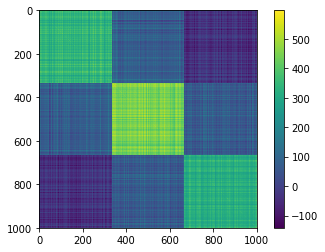

In [28]:
imshow(torch.mm(data[np.argsort(categories)], data[np.argsort(categories)].T))
colorbar()

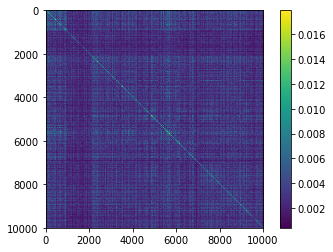

In [17]:
imshow(torch.mm(distance[np.argsort(output_labels)], distance[np.argsort(output_labels)].T))
colorbar()

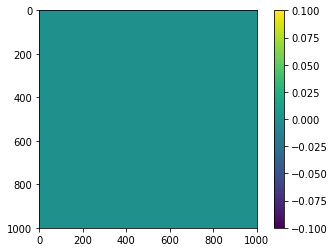

In [19]:
imshow(torch.mm(distance_2[np.argsort(categories)], distance_2[np.argsort(categories)].T))
colorbar()

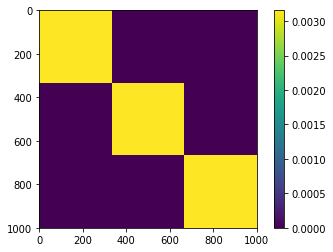

In [13]:
imshow(np.dot(Y[np.argsort(categories)], Y[np.argsort(categories)].T))
colorbar()

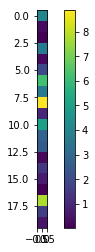

In [155]:
imshow(model.u_minus)
colorbar()

In [ ]:
data.shape

In [ ]:
imshow(torch.mm(distance[np.argsort(categories)].float().T, data[np.argsort(categories)].float()))
colorbar()

In [ ]:
for i in range(20):
    plt.scatter(X[:,0], X[:,1], c=distance[:, i], cmap='Greys', alpha=0.1)
    colorbar()
    plt.show()

In [ ]:
distance

## Evaluate

In [ ]:
evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor())).cuda()
evaluate_y = Variable(test_loader.dataset.test_labels).cuda()


output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().float()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy)

In [ ]:
#output_compare
distance = torch.zeros(3)
correct_count = 0
for k in range(100):
    i = k*15
    inputs = data[i]
    labels = categories[i]
    model = Model(N_INPUT, N_NEURONS, model.Wx, model.Wy, model.Y_hat, Wx_learning_rate_1, Wy_learning_rate_1)
    model_2 = Model(N_INPUT_2, N_NEURONS_2, model_2.Wx, model_2.Wy, model_2.Y_hat, Wx_learning_rate_2, Wy_learning_rate_2)
    outputs = model.forward(inputs.flatten().view(-1, 10).T)
    j = 0
    old_output = model.Y0
    derivative = model.forward(inputs.flatten().view(-1, 10).T)
    outputs = model.updateY(derivative)
    loss = criterion(outputs, old_output)
    j = 0
    while(loss > 10**-5 and j < 10**3):
        old_output = model.Y0
        derivative = model.forward(inputs.flatten().view(-1, 10).T)
        outputs = model.updateY(derivative)
        loss = criterion(outputs, old_output)
        j += 1
    old_output_2 = model_2.Y0
    derivative_2 = model_2.forward(outputs)
    outputs_2 = model_2.updateY(derivative_2)
    loss_2 = criterion(outputs_2, old_output_2)
    j = 0
    while(loss_2 > 10**-5 and j < 10**3):
        old_output_2 = model_2.Y0
        derivative_2 = model_2.forward(outputs)
        outputs_2 = model_2.updateY(derivative_2)
        loss_2 = criterion(outputs_2, old_output_2)
        j += 1
#    distance[i] = outputs.T
    for j in range(2):
        distance[j] = torch.nn.functional.mse_loss(outputs_2.T[0], output_compare[j])
#    print(outputs_2.T)
    print(np.argmin(distance.data.numpy()), '   ', labels)
    if np.argmin(distance.data.numpy()) == labels:
        correct_count += 1
print(float(correct_count)/100)